In [2]:
# from spacy_langdetect import LanguageDetector
# from spacy.language import Language
# import spacy
import pandas as pd
from frequentist_treatment_nlp import *
import nltk
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from nltk.stem.snowball import SnowballStemmer
import regex
import re
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,GRU,LSTM,Embedding, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D, MaxPooling1D, LeakyReLU, Flatten, InputLayer, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, History
import tensorflow as tf
from sklearn.manifold import TSNE

In [3]:
tf.config.list_physical_devices()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [4]:
path = 'C:/Users/32mor/OneDrive/Documents/Polytechnique/NLP & Natixis/starting_kit/data'

In [6]:
os.chdir(path)
X, y_cat, y_reg = hx.data_expander(all_data=True)
y = pd.concat([y_cat,y_reg],axis=1)

In [67]:
unsaved  = False
if unsaved:
     print('unsaved')
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
     pipe_ecb = Full_pipeline_nlp('ecb', 0.3, 300,translate=True)
     pipe_fed = Full_pipeline_nlp('fed',0.3, 300, translate=True)
     pipe_num = numerical_pipeline()
     test_pipe  = full_pipeline(pipe_fed, pipe_ecb, pipe_num)
     X_fed_train, X_ecb_train, X_num_train = test_pipe.fit_transform(X_train)
     X_fed_val, X_ecb_val, X_num_val = test_pipe.transform(X_val)
     X_fed_test, X_ecb_test, X_num_test = test_pipe.transform(X_test)


     y_train_reg = y_train.target_reg
     y_train_cat = y_train.target_classif
     y_test_reg = y_test.target_reg
     y_test_cat = y_test.target_classif
     y_val_reg = y_val.target_reg
     y_val_cat = y_val.target_classif
     os.chdir(path)
     saves = [X_fed_train, X_fed_test, X_fed_val, X_ecb_train, X_ecb_test, 
                    X_ecb_val, X_num_train,X_num_test, X_num_val, y_test_cat,
                    y_test_reg, y_train_reg, y_train_cat, y_val_cat, y_val_reg]
     for element in saves:
          vnames = [name for name in globals() if globals()[name] is element][0]
          np.save(f'{vnames}.npy',element)

else:
     print('saved')
     for element in os.listdir():
          if 'npy' in element :
               if element not in ['element.npy','__.npy']:
                    str = element
                    globals()[str.split('.')[0]] = np.load(element)

day_max = 20
speeches_train = len(X_train)
speeches_val = len(X_val)
speeches_test = len(X_test)
components = 300
X_fed_lstm_train = X_fed_train.reshape((speeches_train, day_max, components))
X_ecb_lstm_train = X_ecb_train.reshape((speeches_train, day_max, components))
X_fed_lstm_test = X_fed_test.reshape((speeches_test, day_max, components))
X_ecb_lstm_test = X_ecb_test.reshape((speeches_test, day_max, components))
X_fed_lstm_val = X_fed_val.reshape((speeches_val, day_max, components))
X_ecb_lstm_val = X_ecb_val.reshape((speeches_val, day_max, components))
lstm_shape = (day_max, components)
shape_num = day_max

saved


In [68]:
def multi_input_output_lstm_full(shape_nlp, shape_num):
    input_nlp_fed = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_nlp_bce = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_num = Input(shape=(shape_num, 1))


    w = LSTM(100, return_sequences=True)(input_nlp_fed)
    w = Dropout(0.3)(w)
    #w = BatchNormalization()(w)
    w = LSTM(40, return_sequences=False)(w)
    w = Dropout(0.3)(w)
    w = Model(inputs=input_nlp_fed, outputs=w)


    x = LSTM(100, return_sequences=True)(input_nlp_bce)
    x = Dropout(0.3)(x)
    #x = BatchNormalization()(x)
    x = LSTM(40, return_sequences=False)(x)
    #x = Dropout(0.3)(x)
    x = Model(inputs=input_nlp_bce, outputs=x)

    # the second branch opreates on the second input
    y = LSTM(100, return_sequences=False)(input_num)
    y = Dropout(0.3)(y)
    #y = BatchNormalization()(y)
    # y = LSTM(40, return_sequences=False)(y)
    # y = Dropout(0.3)(y)
    y = Model(inputs=input_num, outputs=y)
    # combine the output of the two branches
    combined = concatenate([w.output, x.output, y.output])

    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    

    # z = Dense(64, activation='relu')(z)
    # z = Dropout(0.3)(z)
    out_reg = Dense(1, activation='linear')(z)
    
    # dense_class = Dense(40, activation = 'relu')(dropout_2)
    classi = BatchNormalization()(z)
    # classi = Dense(64)(classi)
    # classi = LeakyReLU(0.3)(classi)
    # classi = Dropout(0.5)(classi)
    out_class = Dense(1, activation = 'sigmoid')(classi)
    model = Model(inputs=[w.input, x.input, y.input], outputs=[out_reg, out_class])

    return model

In [69]:
import datetime

In [70]:
model=multi_input_output_lstm_full(lstm_shape, shape_num)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer = Adam(learning_rate=0.0001)
model.compile(loss=['mse',tf.keras.losses.binary_crossentropy], optimizer=optimizer)

In [71]:
history = model.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], [y_train_reg,y_train_cat], epochs=50, batch_size=128, verbose=2,
         callbacks=[early_stop, tensorboard_callback, ], validation_split=0.2)

Epoch 1/50
6/6 - 22s - loss: 1.8984 - dense_12_loss: 1.0159 - dense_13_loss: 0.8824 - val_loss: 1.5730 - val_dense_12_loss: 0.8776 - val_dense_13_loss: 0.6954
Epoch 2/50
6/6 - 10s - loss: 1.7719 - dense_12_loss: 0.9322 - dense_13_loss: 0.8397 - val_loss: 1.5036 - val_dense_12_loss: 0.8080 - val_dense_13_loss: 0.6955
Epoch 3/50
6/6 - 3s - loss: 1.6442 - dense_12_loss: 0.8485 - dense_13_loss: 0.7956 - val_loss: 1.4362 - val_dense_12_loss: 0.7404 - val_dense_13_loss: 0.6959
Epoch 4/50
6/6 - 3s - loss: 1.6043 - dense_12_loss: 0.8150 - dense_13_loss: 0.7893 - val_loss: 1.3718 - val_dense_12_loss: 0.6756 - val_dense_13_loss: 0.6962
Epoch 5/50
6/6 - 3s - loss: 1.4629 - dense_12_loss: 0.7417 - dense_13_loss: 0.7212 - val_loss: 1.3107 - val_dense_12_loss: 0.6145 - val_dense_13_loss: 0.6962
Epoch 6/50
6/6 - 3s - loss: 1.3939 - dense_12_loss: 0.6346 - dense_13_loss: 0.7593 - val_loss: 1.2538 - val_dense_12_loss: 0.5575 - val_dense_13_loss: 0.6963
Epoch 7/50
6/6 - 3s - loss: 1.2877 - dense_12_loss

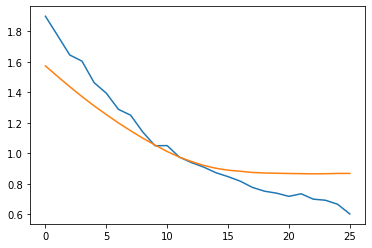

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [86]:
model.save("mutli_inouts_outputs_model")

INFO:tensorflow:Assets written to: mutli_inouts_outputs_model\assets


INFO:tensorflow:Assets written to: mutli_inouts_outputs_model\assets


In [74]:
def multi_input_class_lstm_full(shape_nlp, shape_num):
    input_nlp_fed = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_nlp_bce = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_num = Input(shape=(shape_num, 1))


    w = LSTM(100, return_sequences=True)(input_nlp_fed)
    w = Dropout(0.3)(w)
    #w = BatchNormalization()(w)
    w = LSTM(40, return_sequences=False)(w)
    w = Dropout(0.3)(w)
    w = Model(inputs=input_nlp_fed, outputs=w)


    x = LSTM(100, return_sequences=True)(input_nlp_bce)
    x = Dropout(0.3)(x)
    #x = BatchNormalization()(x)
    x = LSTM(40, return_sequences=False)(x)
    #x = Dropout(0.3)(x)
    x = Model(inputs=input_nlp_bce, outputs=x)

    # the second branch opreates on the second input
    y = LSTM(100, return_sequences=False)(input_num)
    y = Dropout(0.3)(y)
    #y = BatchNormalization()(y)
    # y = LSTM(40, return_sequences=False)(y)
    # y = Dropout(0.3)(y)
    y = Model(inputs=input_num, outputs=y)
    # combine the output of the two branches
    combined = concatenate([w.output, x.output, y.output])

    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    classi = BatchNormalization()(z)
    classi = Dense(64)(classi)
    classi = LeakyReLU(0.3)(classi)
    classi = Dropout(0.5)(classi)
    z = Dense(64, activation='relu')(z)
    z = Dropout(0.3)(z)
    out_reg = Dense(1, activation='linear')(z)
    
    out_class = Dense(1, activation = 'sigmoid')(z)
    model = Model(inputs=[w.input, x.input, y.input], outputs=out_class)

    return model

In [81]:
model_cat=multi_input_class_lstm_full(lstm_shape, shape_num)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer = Adam(learning_rate=0.0001)
model_cat.compile(loss=['mse'], optimizer=optimizer)
history = model_cat.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], y_train_cat, epochs=50, batch_size=128, verbose=2,
    validation_data = ([X_fed_lstm_val, X_ecb_lstm_val, X_num_val], y_val_cat), callbacks=[early_stop, tensorboard_callback, ])

Epoch 1/50
8/8 - 23s - loss: 0.2495 - val_loss: 0.2478
Epoch 2/50
8/8 - 3s - loss: 0.2468 - val_loss: 0.2472
Epoch 3/50
8/8 - 3s - loss: 0.2475 - val_loss: 0.2470
Epoch 4/50
8/8 - 3s - loss: 0.2455 - val_loss: 0.2464
Epoch 5/50
8/8 - 3s - loss: 0.2452 - val_loss: 0.2461
Epoch 6/50
8/8 - 3s - loss: 0.2439 - val_loss: 0.2459
Epoch 7/50
8/8 - 4s - loss: 0.2434 - val_loss: 0.2456
Epoch 8/50
8/8 - 3s - loss: 0.2426 - val_loss: 0.2453
Epoch 9/50
8/8 - 4s - loss: 0.2414 - val_loss: 0.2451
Epoch 10/50
8/8 - 3s - loss: 0.2419 - val_loss: 0.2451
Epoch 11/50
8/8 - 3s - loss: 0.2402 - val_loss: 0.2450
Epoch 12/50
8/8 - 3s - loss: 0.2398 - val_loss: 0.2448
Epoch 13/50
8/8 - 3s - loss: 0.2395 - val_loss: 0.2447
Epoch 14/50
8/8 - 3s - loss: 0.2374 - val_loss: 0.2447
Epoch 15/50
8/8 - 3s - loss: 0.2375 - val_loss: 0.2447
Epoch 16/50
8/8 - 3s - loss: 0.2378 - val_loss: 0.2447


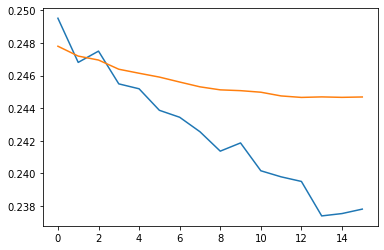

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [87]:
model_cat.save("multi_inputs_class_model")

INFO:tensorflow:Assets written to: multi_inputs_class_model\assets


INFO:tensorflow:Assets written to: multi_inputs_class_model\assets


In [83]:
def multi_input_reg_lstm_full(shape_nlp, shape_num):
    input_nlp_fed = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_nlp_bce = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_num = Input(shape=(shape_num, 1))


    w = LSTM(100, return_sequences=True)(input_nlp_fed)
    w = Dropout(0.3)(w)
    #w = BatchNormalization()(w)
    w = LSTM(40, return_sequences=False)(w)
    w = Dropout(0.3)(w)
    w = Model(inputs=input_nlp_fed, outputs=w)


    x = LSTM(100, return_sequences=True)(input_nlp_bce)
    x = Dropout(0.3)(x)
    #x = BatchNormalization()(x)
    x = LSTM(40, return_sequences=False)(x)
    #x = Dropout(0.3)(x)
    x = Model(inputs=input_nlp_bce, outputs=x)

    # the second branch opreates on the second input
    y = LSTM(100, return_sequences=False)(input_num)
    y = Dropout(0.3)(y)
    #y = BatchNormalization()(y)
    # y = LSTM(40, return_sequences=False)(y)
    # y = Dropout(0.3)(y)
    y = Model(inputs=input_num, outputs=y)
    # combine the output of the two branches
    combined = concatenate([w.output, x.output, y.output])

    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    # classi = BatchNormalization()(z)
    # classi = Dense(64)(classi)
    # classi = LeakyReLU(0.3)(classi)
    # classi = Dropout(0.5)(classi)
    z = Dense(64, activation='relu')(z)
    z = Dropout(0.3)(z)
    out_reg = Dense(1, activation='linear')(z)
    
    # out_class = Dense(1, activation = 'sigmoid')(z)
    model = Model(inputs=[w.input, x.input, y.input], outputs=out_reg)

    return model

In [84]:
model_reg=multi_input_reg_lstm_full(lstm_shape, shape_num)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer = Adam(learning_rate=0.0001)
model_reg.compile(loss=['mse'], optimizer=optimizer)
history = model_reg.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], y_train_reg, epochs=50, batch_size=128, verbose=2,
    validation_data = ([X_fed_lstm_val, X_ecb_lstm_val, X_num_val], y_val_reg), callbacks=[early_stop, tensorboard_callback, ])

Epoch 1/50
8/8 - 19s - loss: 0.9947 - val_loss: 1.4107
Epoch 2/50
8/8 - 4s - loss: 0.9405 - val_loss: 1.3444
Epoch 3/50
8/8 - 3s - loss: 0.8848 - val_loss: 1.2822
Epoch 4/50
8/8 - 3s - loss: 0.8316 - val_loss: 1.2173
Epoch 5/50
8/8 - 3s - loss: 0.7848 - val_loss: 1.1421
Epoch 6/50
8/8 - 3s - loss: 0.7432 - val_loss: 1.0573
Epoch 7/50
8/8 - 3s - loss: 0.6736 - val_loss: 0.9643
Epoch 8/50
8/8 - 3s - loss: 0.6141 - val_loss: 0.8688
Epoch 9/50
8/8 - 8s - loss: 0.5224 - val_loss: 0.7745
Epoch 10/50
8/8 - 3s - loss: 0.5019 - val_loss: 0.6827
Epoch 11/50
8/8 - 3s - loss: 0.4174 - val_loss: 0.5981
Epoch 12/50
8/8 - 3s - loss: 0.3840 - val_loss: 0.5229
Epoch 13/50
8/8 - 3s - loss: 0.3579 - val_loss: 0.4702
Epoch 14/50
8/8 - 3s - loss: 0.3563 - val_loss: 0.4424
Epoch 15/50
8/8 - 3s - loss: 0.3322 - val_loss: 0.4360
Epoch 16/50
8/8 - 3s - loss: 0.2972 - val_loss: 0.4202
Epoch 17/50
8/8 - 3s - loss: 0.3189 - val_loss: 0.4011
Epoch 18/50
8/8 - 3s - loss: 0.2856 - val_loss: 0.3812
Epoch 19/50
8/8 - 

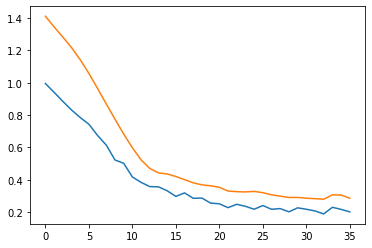

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [88]:
model_reg.save("multi_inputs_reg_model")

INFO:tensorflow:Assets written to: multi_inputs_reg_model\assets


INFO:tensorflow:Assets written to: multi_inputs_reg_model\assets


In [ ]:
mean_squared_error(y_train_reg, model.predict([X_fed_lstm_train, X_ecb_lstm_train, X_num_train]))**(1/2)

os.chdir('C:/Users/32mor/OneDrive/Documents/Polytechnique/NLP & Natixis/starting_kit/answer')

np.savetxt(f'./{version}/pred_reg.txt', y_test_reg, fmt='%.3f')
np.savetxt(f'./{version}/pred_classif.txt', y_test_class, fmt='%d')

In [ ]:
(y_test_class>0.5).sum()

In [ ]:
os.chdir('..')
print('zipping it...')
shutil.make_archive('answer', 'zip', './answer/')
shutil.rmtree('./answer/')
os.chdir('../..')
print('done!')

In [ ]:
os.chdir('C:/Users/32mor/OneDrive/Documents/Polytechnique/NLP & Natixis/starting_kit/answer')